# Task 6 Predictive Modeling

In [14]:
import pandas as pd
df = pd.read_csv("test_labeled (6).xls")

## Add the sentiment score column

In [15]:
#convert date column into datetime format
df['date'] = pd.to_datetime(df['date'])
#create a new column to respresnt the month of the message
df['year_month'] = df['date'].dt.to_period('M')

#create a dictionary to store label scores
sentiment_score_map = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

#create a new column that map from the label in sentiment column to a score based on the created dictionary 
df['sentiment_score'] = df['sentiment'].map(sentiment_score_map)

## Add new features to dataframe

In [16]:
df['message_length'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))

# Group by sender and month
monthly_df = df.groupby(['from', 'year_month']).agg({
    'sentiment_score': 'mean',
    'body': 'count',
    'message_length': 'mean',
    'word_count': 'mean'
}).reset_index()

# Rename columns
monthly_df.rename(columns={
    'body': 'message_count',
    'message_length': 'avg_msg_length',
    'word_count': 'avg_word_count'
}, inplace=True)

# Split and train model

In [17]:
from sklearn.model_selection import train_test_split

# Select features and target
X = monthly_df[['message_count', 'avg_msg_length', 'avg_word_count']]
y = monthly_df['sentiment_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

# Predict and evaluation 

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R^2: {r2:.3f}")

MAE: 0.137
MSE: 0.037
R^2: 0.140


In [20]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
print(coef_df)

          Feature  Coefficient
0   message_count    -0.002735
1  avg_msg_length    -0.002412
2  avg_word_count     0.015853


In [21]:
monthly_df['predicted_score'] = lr_model.predict(X)
monthly_df.to_csv('predicted_sentiment_scores.csv', index=False)

# Visualization

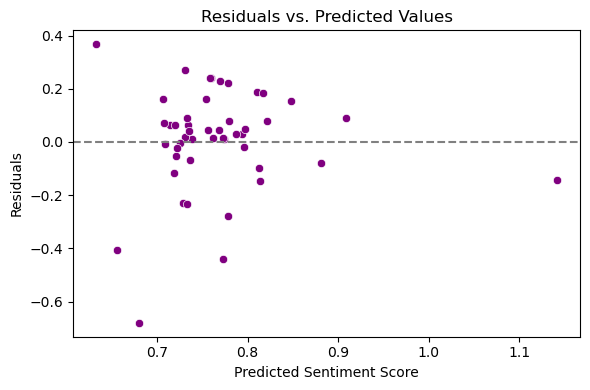

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Sentiment Score')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


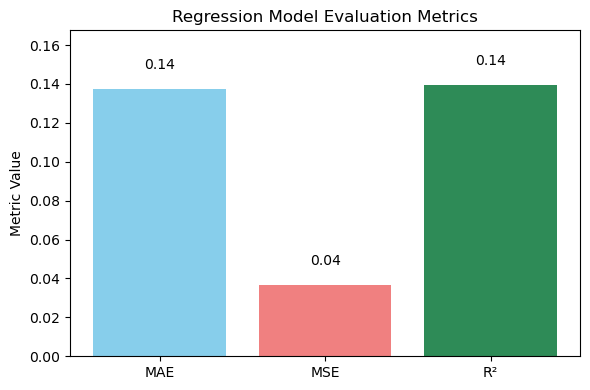

In [24]:
metrics = ['MAE', 'MSE', 'R²']
values = [mae, mse, r2]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'seagreen'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center')

plt.title('Regression Model Evaluation Metrics')
plt.ylim(0, max(values)*1.2)
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()